In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [2]:
dataset = '../model/point_history_classifier/point_history.csv'
model_save_path = '../model/point_history_classifier/point_history_classifier.hdf5'
tflite_save_path = '../model/point_history_classifier/point_history_classifier.tflite'

# Set number of classes

In [3]:
NUM_CLASSES = 6

# input length

In [4]:
TIME_STEPS = 16
DIMENSION = 2

# Load learning data

In [5]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (TIME_STEPS * DIMENSION) + 1)))

In [6]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [8]:
use_lstm = False
model = None

if use_lstm:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Reshape((TIME_STEPS, DIMENSION), input_shape=(TIME_STEPS * DIMENSION, )), 
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(16, input_shape=[TIME_STEPS, DIMENSION]),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
else:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

In [9]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 24)                792       
                                                                 
 dropout_1 (Dropout)         (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                250       
                                                                 
 dense_2 (Dense)             (None, 6)                 66        
                                                                 
Total params: 1,108
Trainable params: 1,108
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early termination
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [11]:
# model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# model training

In [12]:
history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
1/3 [=========>....................] - ETA: 2s - loss: 1.8011 - accuracy: 0.1797
Epoch 1: saving model to ../model/point_history_classifier\point_history_classifier.hdf5
3/3 [==============================] - 2s 467ms/step - loss: 1.8060 - accuracy: 0.1530 - val_loss: 1.7858 - val_accuracy: 0.1489
Epoch 2/1000
1/3 [=========>....................] - ETA: 0s - loss: 1.7981 - accuracy: 0.2422
Epoch 2: saving model to ../model/point_history_classifier\point_history_classifier.hdf5
3/3 [==============================] - 0s 90ms/step - loss: 1.7896 - accuracy: 0.2135 - val_loss: 1.7684 - val_accuracy: 0.2340
Epoch 3/1000
1/3 [=========>....................] - ETA: 0s - loss: 1.7751 - accuracy: 0.2031
Epoch 3: saving model to ../model/point_history_classifier\point_history_classifier.hdf5
3/3 [==============================] - 0s 66ms/step - loss: 1.7669 - accuracy: 0.2313 - val_loss: 1.7516 - val_accuracy: 0.3298
Epoch 4/1000
1/3 [=========>....................] - ETA: 0s - loss

In [13]:
# Loading a saved model
model = tf.keras.models.load_model(model_save_path)

In [14]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 311ms/step
[0.67528826 0.01550179 0.02889357 0.02909672 0.08468993 0.16652983]
0


# Draw Loss and Accuracy

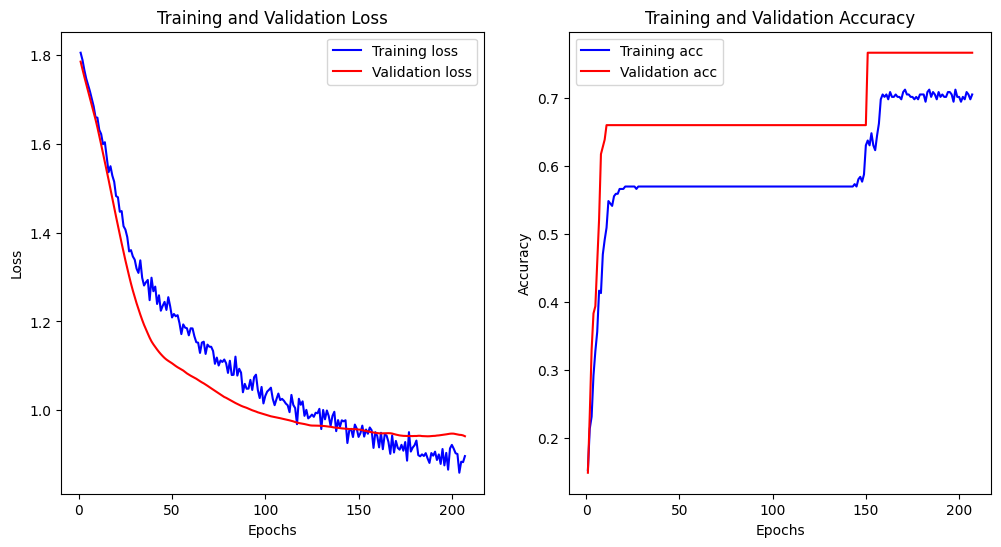

In [15]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Lấy thông tin về loss và accuracy từ history
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(loss) + 1)

    # Vẽ biểu đồ Loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Vẽ biểu đồ Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_training_history(history)

# confusion matrix

3/3 [==============================] - 0s 12ms/step


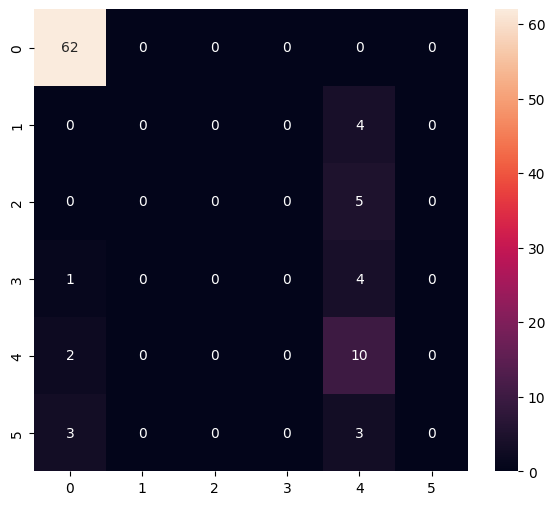

Classification Report
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        62
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         5
           4       0.38      0.83      0.53        12
           5       0.00      0.00      0.00         6

    accuracy                           0.77        94
   macro avg       0.22      0.31      0.25        94
weighted avg       0.65      0.77      0.70        94



c:\Users\ADMIN\anaconda3\envs\env1\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ADMIN\anaconda3\envs\env1\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ADMIN\anaconda3\envs\env1\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [17]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)
model = tf.keras.models.load_model(model_save_path)

In [18]:
# Transform model (quantization)
converter = tf.lite.TFLiteConverter.from_keras_model(model)  # converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\ADMIN\AppData\Local\Temp\tmp0sj0qyl3\assets


6520

# Inference test

In [19]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [20]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)

[{'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([ 1, 32]), 'shape_signature': array([-1, 32]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [21]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [22]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 1.18 ms


In [23]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[0.6752882  0.01550179 0.02889357 0.02909672 0.08468992 0.16652982]
0
